# Setup

In [2]:
import kagglehub

install = False
if install:
    path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

    print("Path to dataset files:", path)

In [3]:
import pandas as pd
import os

# path to the dataset files so don't have to run above cell again
path = os.path.expanduser('~') +  "/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1"

# read data into dataframe
data_30_sec = pd.read_csv(path + "/Data/features_30_sec.csv")
data_3_sec = pd.read_csv(path + "/Data/features_3_sec.csv")

# Exploratory data analysis

In [4]:
# standard imports
import matplotlib.pyplot as plt
import seaborn as sb
import librosa
import numpy as np

plt.style.use('ggplot')

In [5]:
# missing data?
data_30_sec.head(10)
data_30_sec.describe()
data_30_sec.isnull().sum() # no missing data, data seems clean

filename                   0
length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean                 0
mfcc8_var     

## Basic plots with metadata 

Text(0.5, 1.0, 'Correlation between features')

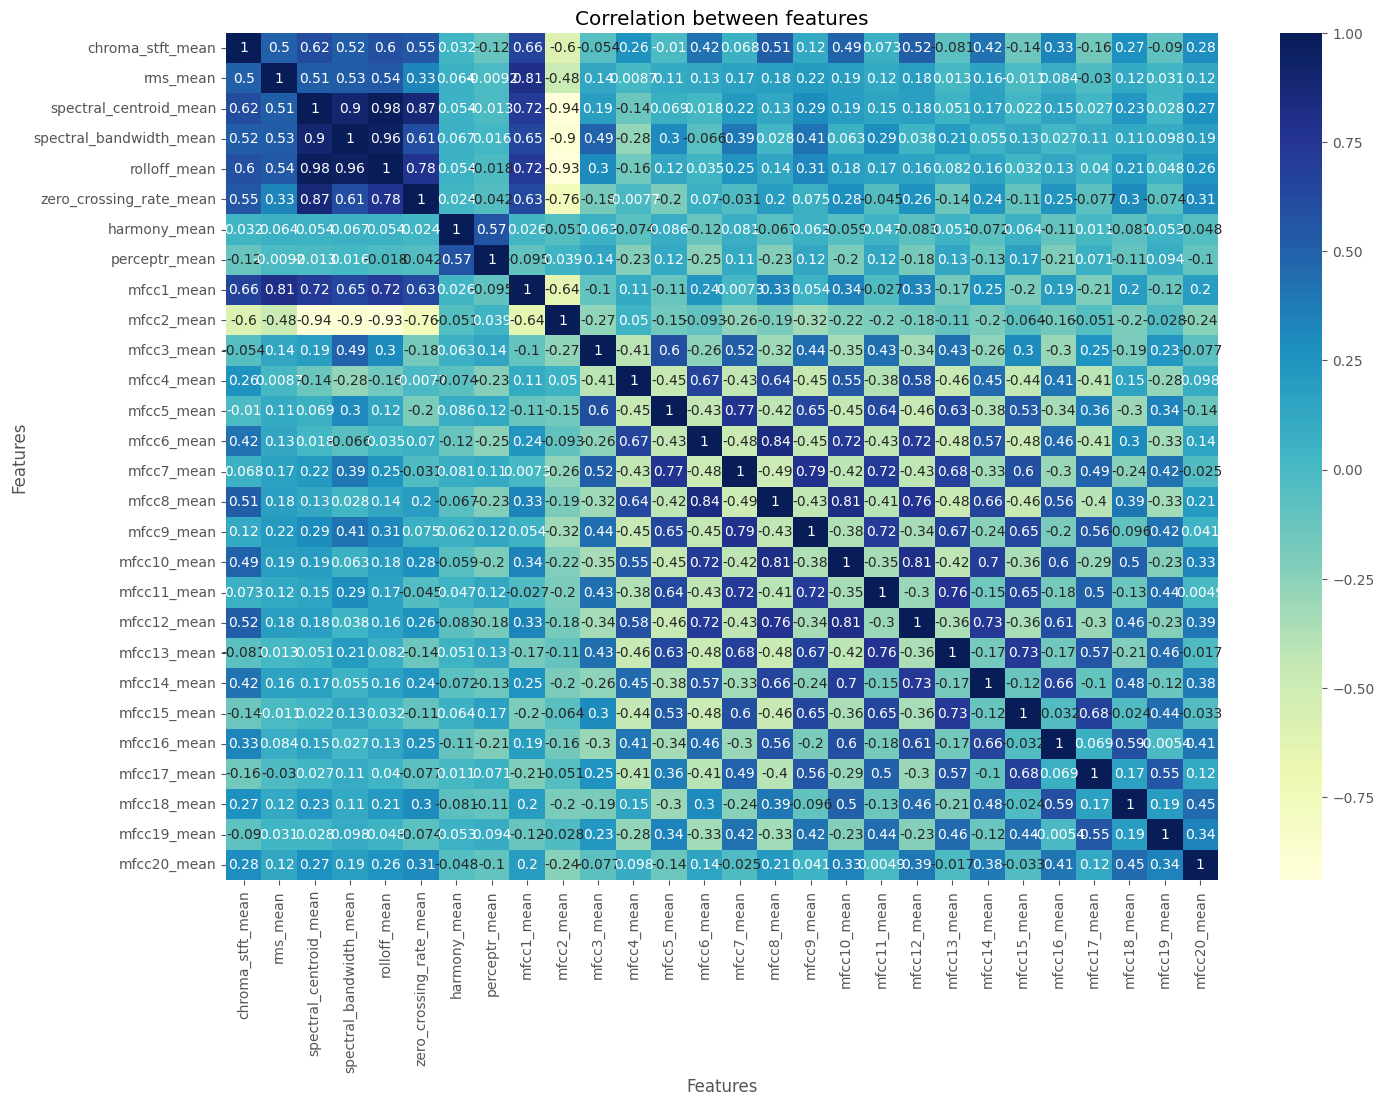

In [6]:
# Getting all the columns that have the mean data
mean_cols = [col for col in data_30_sec.columns if 'mean' in col]

fig, ax = plt.subplots(figsize=(16, 11));

dataplot = sb.heatmap(data_30_sec[mean_cols].corr(numeric_only=True), cmap="YlGnBu", annot=True)
ax.set_xlabel('Features')
ax.set_ylabel('Features')
ax.set_title('Correlation between features')
# There seems to be lots of moderately strong correlations between features, which should be useful in classification

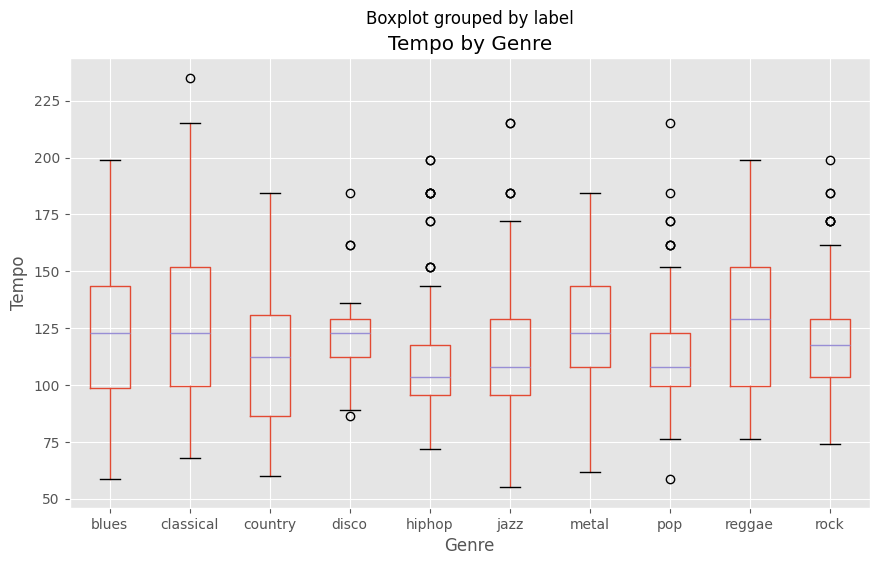

In [7]:
# plot tempo by genre
fig, ax = plt.subplots(figsize=(10, 6))
data_30_sec[['label', 'tempo']].boxplot(by = "label",ax=ax)
ax.set_title("Tempo by Genre")
ax.set_xlabel("Genre")
ax.set_ylabel("Tempo")
plt.show()

# Tempo seems somewhat predictive of genre but there is a lot of overlap between genres

## Looking at the actual music data

In [8]:
# Create an array of all the songs
all_songs = {
    file:path + "/Data/genres_original/" + genre + "/" + file
        for genre in os.listdir(path + "/Data/genres_original") 
            if genre[0] != '.'
            for file in os.listdir(path + "/Data/genres_original/" + genre) 
                if file.endswith(".wav")
}

In [9]:
import random
import os
import librosa

# Choose a random music file
music_data_path = path + "/Data/genres_original/"
genre = ''
while not genre:
    genre = random.choice(os.listdir(music_data_path))
    
    # Skip if we come across some kind of hidden file
    if (genre[0] == '.'):
        genre = ''

music_data_path += f'{genre}/'
music_data_path += random.choice(os.listdir(music_data_path))

x , sr = librosa.load(music_data_path)

### Waveplot

<class 'numpy.ndarray'> <class 'int'>
(661794,) 22050
rock


Text(0.5, 1.0, 'Waveplot of the song from the rock genre')

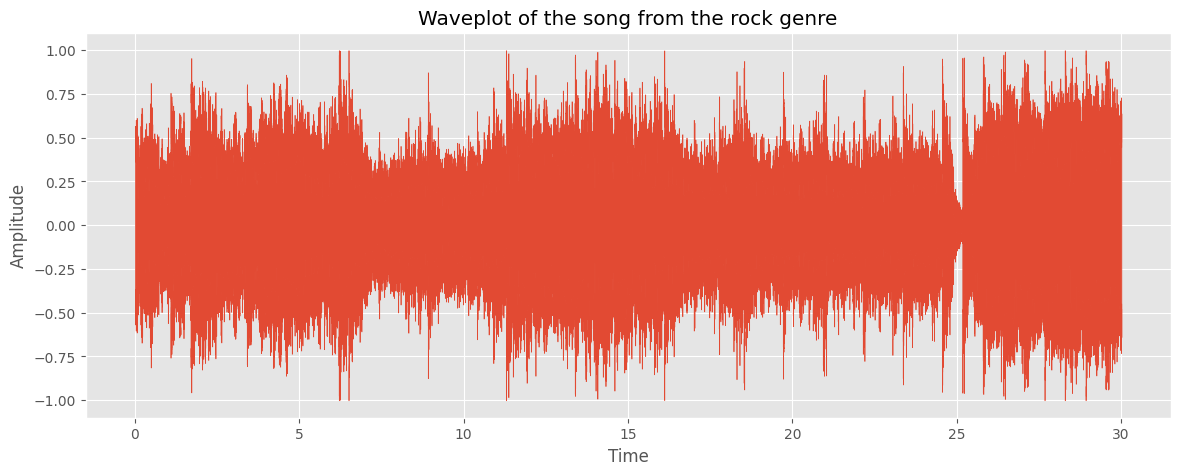

In [10]:
# the random song:
import IPython.display as ipd
import librosa.display

print(type(x), type(sr))
print(x.shape, sr)
print(genre)
ipd.Audio(x, rate=sr)

plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr) 
plt.ylabel("Amplitude")
plt.title(f'Waveplot of the song from the {genre} genre')

### Spectrogram
#### Shows the variation in the sound frequencies in the song

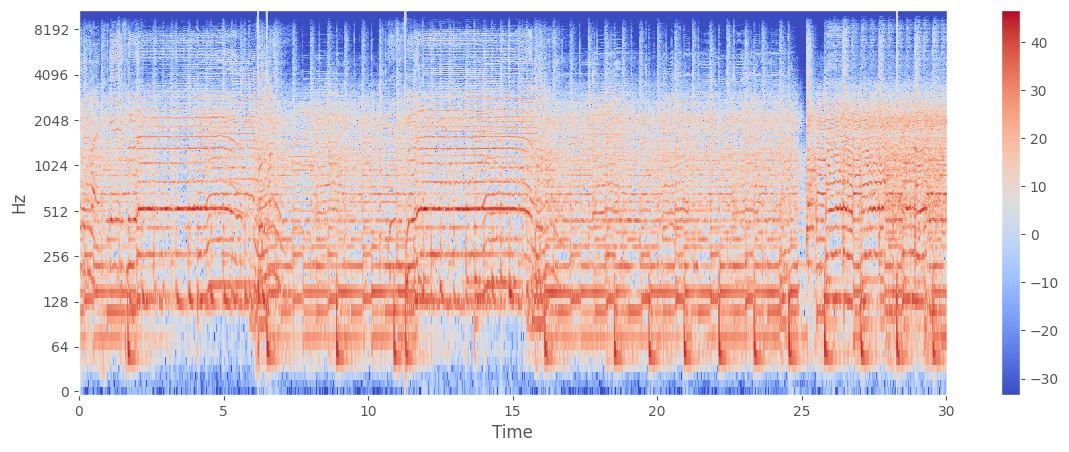

In [11]:
X = librosa.stft(x) # performs a fourier transform on the data
Xdb = librosa.amplitude_to_db(abs(X)) # converts the amplitude to decibels


# plotting
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

### Feature extraction 1: Zero crossing rate
#### The rate at which the signal changes from positive to negative, percussive music like metal and rock tend to have a higher zero crossing rate

9


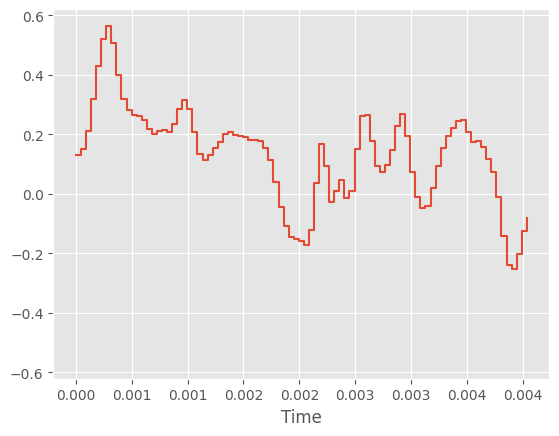

In [12]:
# Using a smaller window size so we can see what's happening
start = 10
end =  100
librosa.display.waveshow(x[start: end], sr=sr)

zero_crossings = librosa.zero_crossings(x[start:end], pad=False)
print(sum(zero_crossings)) # the signal crosses with the x-axis this many times

In [13]:
# Extract all the zero crossing rates from all songs
%pip install soundfile
import librosa
import soundfile as sf

zero_crossing_rates = {}

# process is too long to complete
if False:
    for name, path in all_songs.items():
        tempdata, tempsr = librosa.load(path)
        zero_crossings = librosa.zero_crossings(tempdata, pad=False)
        zero_crossing_rates[name] = sum(zero_crossings)

    print(zero_crossing_rates)


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Feature extraction 2 : Spectral Centroid
#### The 'Centre of Mass' of a song. Where there is the weighted mean of the frequencies of a song

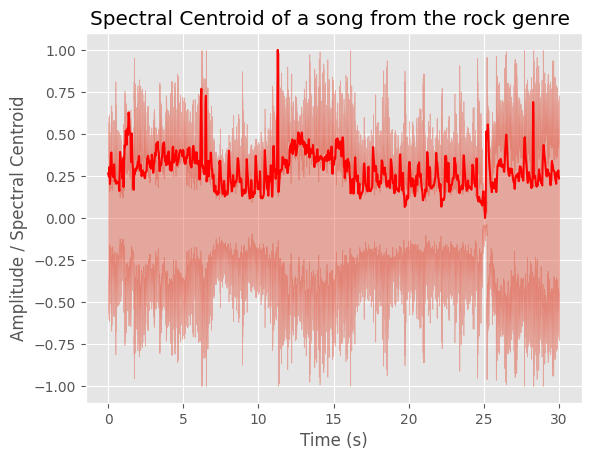

In [14]:
# This code is taken from the second article in 'README.md'
import sklearn

spectral_centroids = librosa.feature.spectral_centroid(y = x, sr=sr)[0]

# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

# Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.title("Spectral Centroid of a song from the " + genre + " genre ")
plt.plot(t, normalize(spectral_centroids), color='r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude / Spectral Centroid')

# To listen to the song
ipd.Audio(x, rate=sr) 

### Feature extraction 3: Spectral Rolloff
#### Spectral rolloff is the frequency below which x % of the frequency lives. It is the upper bound frequency

Text(22.347222222222214, 0.5, 'Threshold')

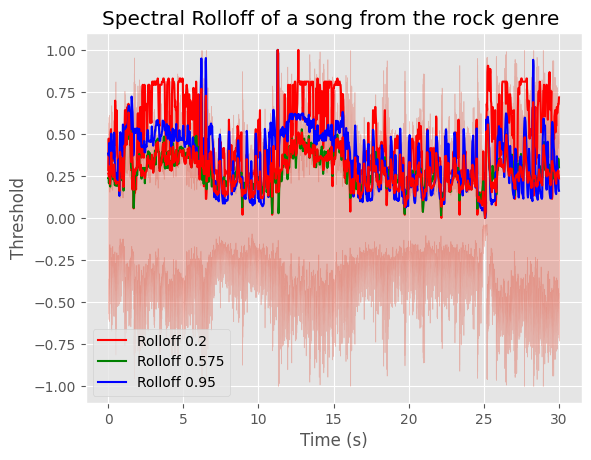

In [15]:


for perc, col in zip(np.linspace(start = 0.2, stop = 0.95, num = 3), ('r', 'g', 'b')):

    spec_rolloff = librosa.feature.spectral_rolloff(y = x, sr = sr, roll_percent = perc)[0]

    plt.plot(t, normalize(spec_rolloff), color = col)

librosa.display.waveshow(x, sr=sr, alpha=0.3)
plt.title("Spectral Rolloff of a song from the " + genre + " genre ")
plt.plot(t, normalize(spectral_centroids), color='r')
plt.xlabel('Time (s)')
plt.legend(['Rolloff 0.2', 'Rolloff 0.575', 'Rolloff 0.95'], loc='best')
plt.ylabel('Threshold')

### Feature Extraction 4: Chroma Frequencies
#### Chroma frequencies shows you the octaves used throughout the song

Text(0.5, 1.0, 'Chroma frequency graph for a rock song')

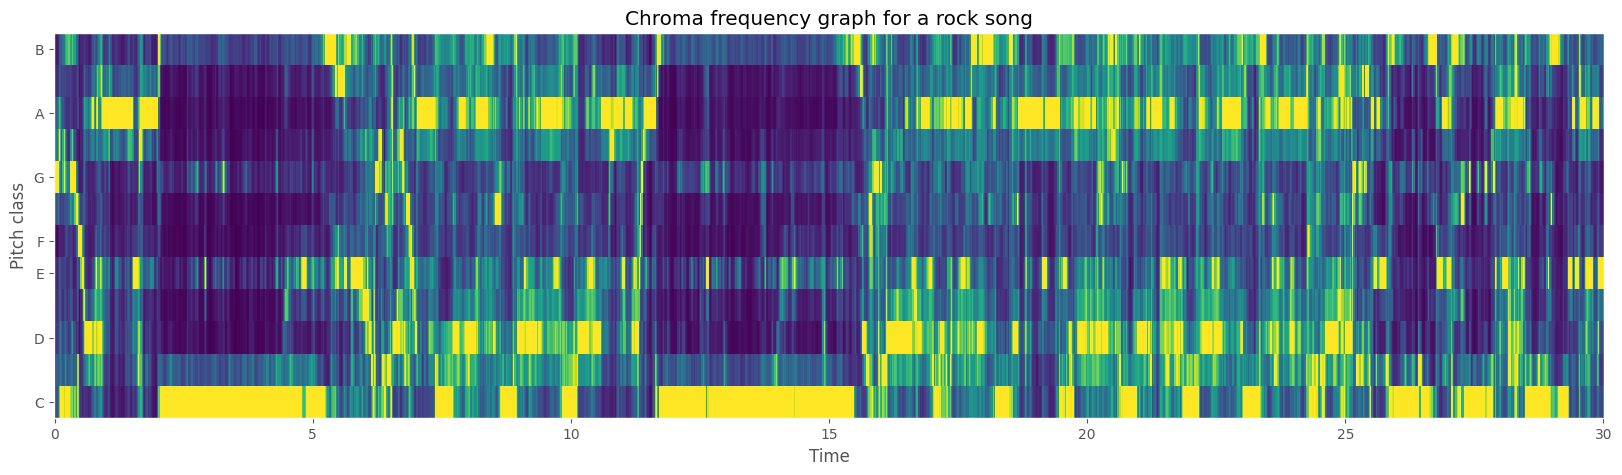

In [16]:
hop_length = 512
chroma = librosa.feature.chroma_stft(y = x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(20, 5))
librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='viridis')
plt.title("Chroma frequency graph for a " + genre + " song")

# Machine learning goals

### Main Goal: Accurately classify unseen songs into one of the given genres using the following 
1. PCA
1. KNN 
1. SVM
1. Random Forest
1. Neural Network

#### Sub-Goal: Discover the best method for identifying fusion songs, that is songs that are somewhat in-between two genres by using only non-fusion training data


In [17]:
from sklearn.model_selection import train_test_split 

x_train, x_test = train_test_split(data_30_sec.drop(["filename"], axis = 1), test_size=0.2 , random_state=0)

y_test = x_test["label"]
y_train = x_train["label"]
x_train = x_train.drop(["label"], axis = 1)
x_test = x_test.drop(["label"], axis = 1)


In [18]:
x_test

length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
993  661794          0.343449         0.081881  0.105779  0.000480   
859  661504          0.375856         0.085602  0.126457  0.001965   
298  661794          0.270818         0.086876  0.176322  0.003653   
553  661794          0.311716         0.089816  0.130096  0.001595   
672  661504          0.445193         0.080381  0.194409  0.000769   
..      ...               ...              ...       ...       ...   
679  661504          0.472406         0.072405  0.127426  0.001773   
722  661504          0.386878         0.089062  0.196097  0.006238   
215  661794          0.379448         0.079580  0.104801  0.000668   
653  661794          0.492827         0.078170  0.227499  0.002003   
150  661794          0.286093         0.084303  0.007976  0.000017   

     spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
993             1939.720838          158701.603337              1881.515156   
859             2671.459793          823178.771786              2716.559623   
298             1425.010296          268097.794804              1690.948858   
553             1804.590753          297896.826331              1861.618734   
672             2339.714908          123698.944730              2151.982682   
..                      ...                    ...                      ...   
679             2710.543163          247566.872819              2264.313137   
722             3206.738943          837543.819245              3126.229971   
215             1958.677390          356482.601840              2146.416728   
653             2906.766679          118853.054261              2374.746552   
150             1170.028076           48596.253358              1595.365294   

     spectral_bandwidth_var  rolloff_mean  ...  mfcc16_mean  mfcc16_var  \
993            91092.876566   3748.509326  ...     3.375859   32.674183   
859           203466.668347   5699.270977  ...    -4.382725   61.214920   
298           119640.688974   2980.125367  ...     1.981501   70.231689   
553            38691.061629   3646.364004  ...    -1.862992   86.707741   
672            27112.775777   4707.994218  ...     3.319108   29.045485   
..                      ...           ...  ...          ...         ...   
679            67836.501295   5323.505757  ...     5.546495   56.555176   
722           128185.706484   7019.990756  ...    -2.397979   42.056149   
215           103469.666282   4207.726116  ...    -3.011962   27.552799   
653            46714.416789   5519.011587  ...     7.723671   26.913851   
150            52758.970717   2360.084027  ...     1.215415   38.962044   

     mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  \
993    -7.690068   32.920521     1.608992   34.640530   -10.703717   
859    -4.059788   62.772442    -3.176068   43.734417    -5.431156   
298    -4.184361   78.628334     1.386218   69.707001     2.436887   
553    -0.019071   98.195518    -4.241150   80.778114    -4.228639   
672   -11.964552   36.842892    -1.371892   39.719337    -2.402323   
..           ...         ...          ...         ...          ...   
679    -7.277649   46.166824     2.920027   58.300758    -0.565934   
722    -1.348478   54.826416    -2.877167   78.700165    -0.847281   
215    -5.475275   27.640854    -2.956244   26.237810    -2.640563   
653    -5.390154   26.726738     3.408915   24.453365    -6.927285   
150    -2.287446   47.514862    -4.109840   43.306095    -1.811351   

     mfcc19_var  mfcc20_mean  mfcc20_var  
993   49.267849    -0.542913   43.253307  
859   49.247871    -2.143111   62.694115  
298   70.288208    -3.615434   63.632908  
553  100.662315    -5.644222  133.644608  
672   45.586899    -2.626525   37.638622  
..          ...          ...         ...  
679   58.261131    -2.847489   35.421535  
722   74.693024    -2.597403   65.059059  
215   33.477554    -3.385912   40.309345  
653   29.771788     6.545909   26.920095  


### PCA
There are many different features for each track in the dataset. Applying dimensionality reduction can help simplify the feature space while retaining essential information and removing noise.

I need to do the following:
1. Copy the original data
1. Standardize the data
1. Figure out which components are important and use them

In [19]:
pca_data = data_30_sec.copy().drop(["filename", "length", "label"], axis = 1) # we'll be scaling the data so it's important to use a deep-copy

len(data_30_sec.columns) # 60 columns is a lot! Hopefully we can use PCA to help with that

60

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_data

chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0            0.350088         0.088757  0.130228  0.002827   
1            0.340914         0.094980  0.095948  0.002373   
2            0.363637         0.085275  0.175570  0.002746   
3            0.404785         0.093999  0.141093  0.006346   
4            0.308526         0.087841  0.091529  0.002303   
..                ...              ...       ...       ...   
995          0.352063         0.080487  0.079486  0.000345   
996          0.398687         0.075086  0.076458  0.000588   
997          0.432142         0.075268  0.081651  0.000322   
998          0.362485         0.091506  0.083860  0.001211   
999          0.358401         0.085884  0.054454  0.000336   

     spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0               1784.165850          129774.064525              2002.449060   
1               1530.176679          375850.073649              2039.036516   
2               1552.811865          156467.643368              1747.702312   
3               1070.106615          184355.942417              1596.412872   
4               1835.004266          343399.939274              1748.172116   
..                      ...                    ...                      ...   
995             2008.149458          282174.689224              2106.541053   
996             2006.843354          182114.709510              2068.942009   
997             2077.526598          231657.968040              1927.293153   
998             1398.699344          240318.731073              1818.450280   
999             1609.795082          422203.216152              1797.213044   

     spectral_bandwidth_var  rolloff_mean   rolloff_var  ...  mfcc16_mean  \
0              85882.761315   3805.839606  9.015054e+05  ...     0.752740   
1             213843.755497   3550.522098  2.977893e+06  ...     0.927998   
2              76254.192257   3042.260232  7.840345e+05  ...     2.451690   
3             166441.494769   2184.745799  1.493194e+06  ...     0.780874   
4              88445.209036   3579.757627  1.572978e+06  ...    -4.520576   
..                      ...           ...           ...  ...          ...   
995            88609.749506   4253.557033  1.222421e+06  ...     1.789867   
996            82426.016726   4149.338328  1.046621e+06  ...     3.739020   
997            74717.124394   4031.405321  8.042154e+05  ...     1.838090   
998           109090.207161   3015.631004  1.332712e+06  ...    -2.812176   
999           120115.632927   3246.908930  1.753476e+06  ...     1.794104   

     mfcc16_var  mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  \
0     52.420910    -1.690215   36.524071    -0.408979   41.597103   
1     55.356403    -0.731125   60.314529     0.295073   48.120598   
2     40.598766    -7.729093   47.639427    -1.816407   52.382141   
3     44.427753    -3.319597   50.206673     0.636965   37.319130   
4     86.099236    -5.454034   75.269707    -0.916874   53.613918   
..          ...          ...         ...          ...         ...   
995   45.050526   -13.289984   41.754955     2.484145   36.778877   
996   33.851742   -10.848309   39.395096     1.881229   32.010040   
997   33.597008   -12.845291   36.367264     3.440978   36.001110   
998   46.324894    -4.416050   43.583942     1.556207   34.331261   
999   59.167755    -7.069775   73.760391     0.028346   76.504326   

     mfcc19_mean  mfcc19_var  mfcc20_mean  mfcc20_var  
0      -2.303523   55.062923     1.221291   46.936035  
1      -0.283518   51.106190     0.531217   45.786282  
2      -3.439720   46.639660    -2.231258   30.573025  
3      -0.619121   37.259739    -3.407448   31.949339  
4      -4.404827   62.910812   -11.703234   55.195160  
..           ...         ...          ...         ...  
995    -6.713265   54.866825    -1.193787   49.950665  
996    -7.461491   39.196327    -2.795338   31.773624  
997   -12.588070   42.502201    -2.106337   29.865515

In [21]:
# Scaling is an important part of PCA, otherwise the variance used to determine which features are 'important' is exaggerated by scale

# Create an object of the Std scalar class
scaler = StandardScaler()

scaler.fit(pca_data)
scaled_data = scaler.transform(pca_data)

# pca
principal = PCA(n_components=2)
principal.fit(scaled_data)
x = principal.transform(scaled_data)

principal = PCA(n_components=3)
principal.fit(scaled_data)
y = principal.transform(scaled_data)

print(x.shape)
print(principal.components_)

(1000, 2)
[[-0.0972025   0.17857273 -0.01165984  0.11809886 -0.01735634  0.15892139
   0.02758724  0.15696394 -0.00996695  0.16417255 -0.06949004  0.11393996
   0.02200669  0.02401139  0.06145727  0.04539055 -0.02572285 -0.09710523
   0.15169668 -0.00679755  0.18047644  0.1399991   0.15384058 -0.15436081
   0.1624272   0.15891882  0.14910186 -0.15515837  0.16668638  0.1540799
   0.1416302  -0.16081495  0.17472782  0.14425061  0.17259683 -0.14374318
   0.17139915  0.13185287  0.16403287 -0.15547637  0.16224424  0.1591668
   0.16405884 -0.1165564   0.1552974   0.15652153  0.14962326 -0.11024456
   0.14895931  0.12799744  0.14883461 -0.06187301  0.1416775   0.11081108
   0.14083716 -0.05103557  0.13916931]
 [ 0.24462161 -0.04776484  0.23104773  0.18075926  0.27406517  0.20973408
   0.27856424  0.08390818  0.27941211  0.13676509  0.20037609  0.21291139
   0.02753564  0.17282218  0.00340868  0.22786558 -0.02059292  0.2467733
  -0.01983312 -0.26476654  0.04447303  0.10386178  0.02423994 -0.0

Text(0.5, 1.0, '2 Dimensional PCA with labelled genre')

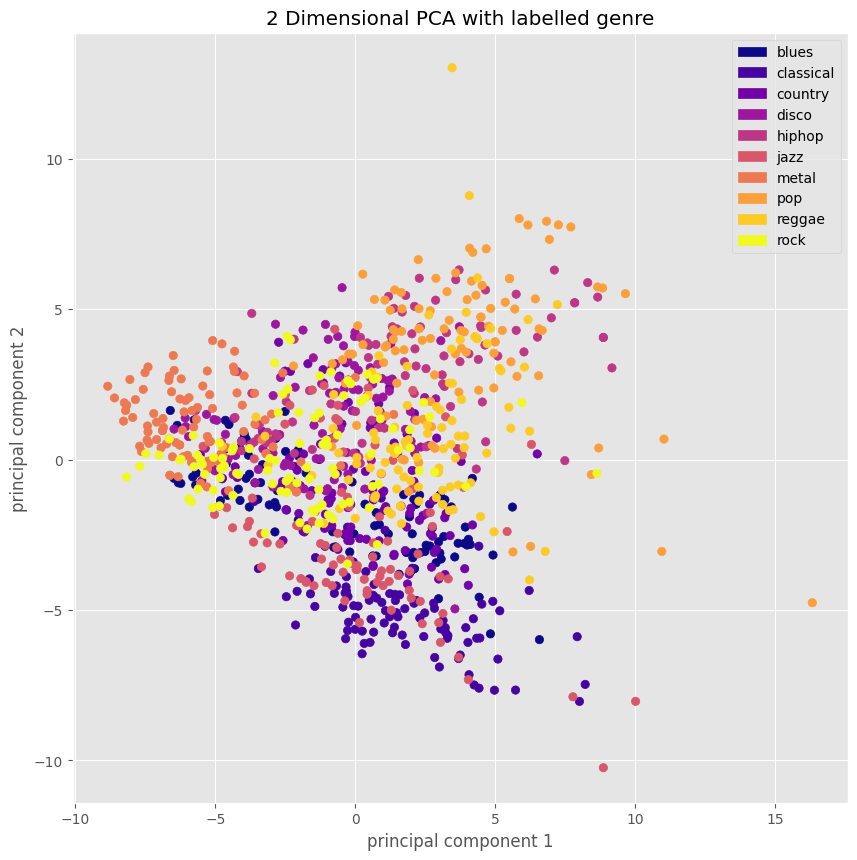

In [22]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches as mpatches

# Encode the genre labels as integers for legend purposes
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(data_30_sec['label'])

plt.figure(figsize=(10,10))
scatter = plt.scatter(x[:,0], x[:,1], c=encoded_labels, cmap='plasma')
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')

# Create a custom legend
handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(i)), label=label) for i, label in enumerate(data_30_sec['label'].unique())]
plt.legend(handles=handles, loc="best")

plt.title("2 Dimensional PCA with labelled genre")

# There seems to be some type of clustering. But not very dense clusters

Text(0.5, 0.92, 'PCA with 3 principle components')

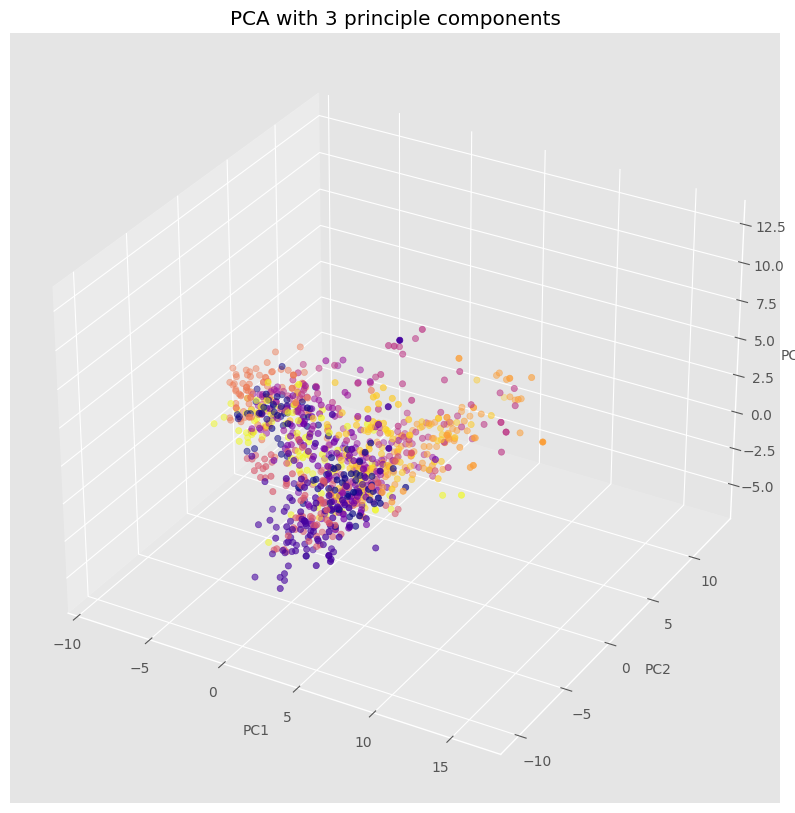

In [23]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
 
axis = fig.add_subplot(111, projection='3d')
 
axis.scatter(y[:,0],y[:,1],y[:,2], c=encoded_labels,cmap='plasma')
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)
axis.set_zlabel("PC3", fontsize=10)
plt.title("PCA with 3 principle components")

Number of components to retain 95.0% of the variance: 33


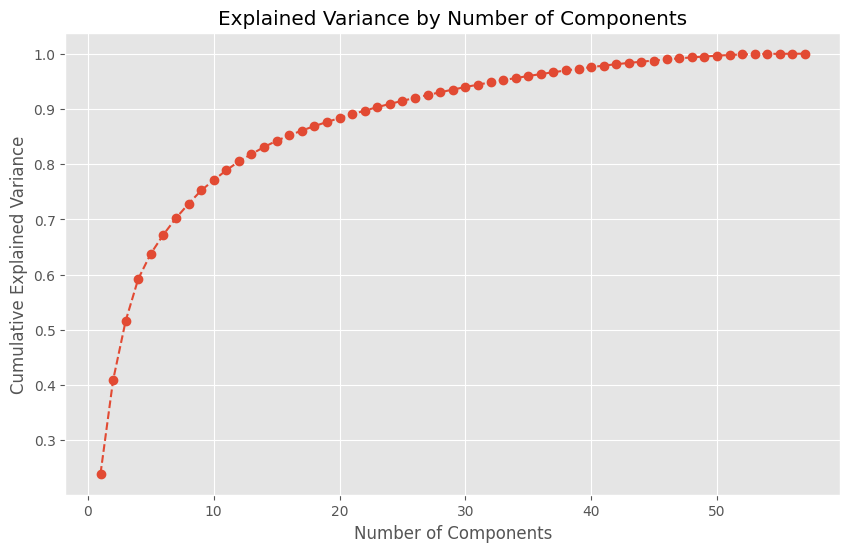

0         1         2         3         4         5         6   \
0   -2.783565 -1.029365 -0.522219 -0.115968  0.713896  0.991845  0.353365   
1    1.727521 -1.165727  1.348139 -2.460894  2.070007  0.050922  0.085213   
2   -2.815019 -1.571601 -0.088108 -1.597084 -0.706319  1.712740  0.533627   
3    0.345751 -1.480620 -1.524833 -1.898620  1.892882  2.363926  0.225157   
4    0.624704 -3.201114  0.136860 -2.214052 -3.253498 -0.042810  1.481521   
..        ...       ...       ...       ...       ...       ...       ...   
995 -4.858414 -1.539852  0.633166 -1.190824 -0.656577 -0.744381 -0.334401   
996 -5.851727 -1.396035 -0.200347 -1.008790 -0.363527 -0.736680  0.158622   
997 -5.943121 -1.298427  0.443109 -1.663806 -1.643798 -1.020319  0.492229   
998 -0.799352 -1.968622 -0.359356 -2.831155  1.361937  0.119921  0.021799   
999 -1.293732 -2.112672  0.856818 -1.466786  1.212644 -0.952420 -0.579859   

           7         8         9   ...        23        24        25  \
0    0.400635  0.172261 -0.349387  ...  0.408720 -0.318512 -0.178949   
1    0.126410  0.930189 -1.282137  ...  0.743583 -0.710539  0.453143   
2    0.249661 -0.459833  0.647996  ... -0.417123 -0.296651  0.028204   
3    0.014581  0.471199 -0.469569  ... -0.284548 -0.093061  0.146748   
4   -0.037387 -1.249848  0.890086  ...  0.324532 -0.009182 -0.238066   
..        ...       ...       ...  ...       ...       ...       ...   
995  0.724816  1.087247  0.023919  ...  0.290288  0.453265  0.128631   
996  0.782728  0.791695  0.855418  ...  0.387077  0.245702 -0.188776   
997  0.554715  0.218816  0.835184  ... -0.281731  0.807458 -0.491130   
998  0.692058  0.381163 -1.103411  ...  0.886813  0.358014 -1.069663   
999  1.548851  0.104161 -0.556296  ...  0.379594  0.318248 -0.338883   

           26        27        28        29        30        31        32  
0   -0.299621  0.215001  0.462916  0.119704 -0.092836  0.147350 -0.119260  
1    0.277100  0.533478 -0.019182  0.281338  0.278114  0.370641  0.129579  
2    0.415367 -0.374945  0.273955  0.309790  0.313011  0.100814  1.292509  
3   -0.159055 -0.080939  0.051411 -0.605193 -0.268799  0.269199  0.120001  
4    0.031028  0.459478  0.979734 -0.877399  0.378860  0.320338  0.924299  
..        ...       ...       ...       ...       ...       ...       ...  
995 -0.180423  0.113034 -0.398029 -0.688777 -0.211797 -0.560302 -0.435031  
996  0.307412 -0.658482 -0.370345 -0.454207 -0.461383 -0.349619 -0.335739  
997 -0.331704 -0.044584  0.377647  0.031966 -0.286151 -0.611234 -0.328704  
998  0.099569 -0.099835 -0.926004 -0.335065  0.242595  0.131400 -0.653076  
999  0.087985  0.310773 -0.359558 -0.176974 -0.719977  0.209044  0.057629  

[1000 rows x 33 columns]

In [24]:
# Fit PCA with all components
pca = PCA()
pca.fit(scaled_data)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

# Determine the optimal number of components
optimal_variance = 0.95
num_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= optimal_variance) + 1
print(f"Number of components to retain {optimal_variance*100}% of the variance: {num_components}")
plt.title('Explained Variance by Number of Components')
plt.show()

# We can explain 95% of the variance with 33 components, which is just more than
# half of the original number of components

# Fit PCA with the optimal number of components
pca_optimal_model = PCA(n_components=num_components)
pca_optimal_model.fit(scaled_data)
pca_optimal = pd.DataFrame(pca_optimal_model.transform(scaled_data))

pca_optimal

In [25]:
sorted(pca_optimal_model.explained_variance_ratio_, reverse=True) # a single feature explains as much as 24% of the variance in the data

[np.float64(0.23949563801262658),
 np.float64(0.16929248180395426),
 np.float64(0.10750027583451688),
 np.float64(0.07601962197646317),
 np.float64(0.04578077302166634),
 np.float64(0.03434982481980523),
 np.float64(0.02994448032848078),
 np.float64(0.025958762511793163),
 np.float64(0.02403186313454476),
 np.float64(0.018784471803682614),
 np.float64(0.01774611239728923),
 np.float64(0.016198010918909093),
 np.float64(0.013152788173097752),
 np.float64(0.01281109527867849),
 np.float64(0.01128946369938246),
 np.float64(0.009705126871548281),
 np.float64(0.008766278659854488),
 np.float64(0.00814671692954216),
 np.float64(0.00740306500357051),
 np.float64(0.0071489647657759225),
 np.float64(0.00675713502642741),
 np.float64(0.006641690913919498),
 np.float64(0.006347210450212119),
 np.float64(0.005871887731428479),
 np.float64(0.005608474006087345),
 np.float64(0.005277907997169654),
 np.float64(0.005182695796818157),
 np.float64(0.005010154408673574),
 np.float64(0.004820959120014715)

## KNN
### The crucial step in KNN is finding the optimal 'K' without overfitting to the data. 

Text(0.5, 0, 'K')

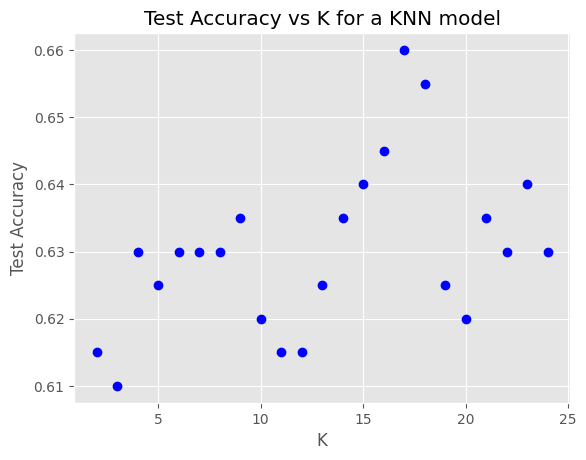

In [26]:
from sklearn.neighbors import KNeighborsClassifier 

ks = list(range(2, 25))  
summary = {} # Score the score for each k
train_scores = []
test_scores = []

# standardize data, important step for knn
scaler = StandardScaler()
scaler.fit(x_train) # make sure the scaler only "knows" about the x_data to prevent data leak

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)


for k in ks:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(x_train, y_train)

    train_scores.append(model.score(x_train, y_train))
    test_scores.append(model.score(x_test, y_test))

    summary[k] = [test_scores[-1], train_scores[-1], model]


# looking at the plot from the data we just obtained:
plt.plot(ks, test_scores, "bo")  # super inaccurate because there is a lot of noise ( too many dimensions)
plt.title("Test Accuracy vs K for a KNN model")
plt.ylabel("Test Accuracy")
plt.xlabel("K")

In [27]:
max_k = int(np.argmax(test_scores))

max_k, test_scores[max_k] # the optimal value for k seems to be 15 with a test accuracy of 0.66

(15, 0.66)

In [28]:
data_30_sec.columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

## SVM

### The goal of SVM is to find a hyperplane in some N-dimensional space (where N is the number of features used) that best divides the data into 'neat' sects (based off of labels). This can then be used to determine to which sect new data most likely belongs.



In [29]:
from sklearn import svm


model_svm = svm.SVC(kernel='rbf',
               gamma=0.1,
               C=10.0)

model_svm = svm.SVC(kernel="linear")
 
model_svm.fit(x_train, y_train)
 
accuracy = model_svm.score(x_test, y_test)
print('Accuracy:', accuracy)


Accuracy: 0.65
